# project description

This project tries to train a model to predict if a student can be admitted to a graduate school based on features including GPA, GRE score and undergraduate school ranks. 

The source dataset can be found at  https://stats.idre.ucla.edu/stat/data/binary.csv

This problem was originally presented in Udacity. I found it was a perfect fit for myself to practice the basic techniques, such as data pre-preparation, define model, loss function, and gradient descent method to minimize loss function. 

Solution: multiple layer model including one hidden layer. Overall structure is similar to the single layer model.

* build a network with one hidden layer and one output layer
* use sigmoid function as output activation function
* use MSE (mean square error) as the loss function
* use gradient descent method to minimize the loss function




## (1) Import needed libraries

In [1]:
import numpy as np
import pandas as pd

## (2) load dataset and pre-processing

### load data using pandas

In [2]:
# read csv data using pandas
admissions = pd.read_csv('binary.csv')
admissions.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


### pre-processing data

* **make dummy variables for rank**

(1) **pandas.get_dummies**(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False)

Convert categorical variable into dummy/indicator variables

*Parameters*:	
**data** : array-like, Series, or DataFrame

**prefix** : string, list of strings, or dict of strings, default None
String to append DataFrame column names Pass a list with length equal to the number of columns when calling get_dummies on a DataFrame. Alternatively, prefix can be a dictionary mapping column names to prefixes.

**prefix_sep** : string, default ‘_’

*Returns*
**dummies** : DataFrame or SparseDataFrame

(2) **concatenate objects along a particular axis with optional set logic along the other axes **

**pandas.concat**(objs, axis=0, join='outer', join_axes=None, ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, copy=True)

**objs** : a sequence or mapping of Series, DataFrame, or Panel objects
If a dict is passed, the sorted keys will be used as the keys argument, unless it is passed, in which case the values will be selected (see below). Any None objects will be dropped silently unless they are all None in which case a ValueError will be raised

**axis** : {0/’index’, 1/’columns’}, default 0
The axis to concatenate along

In [3]:
# Make dummy variables for rank
data = pd.concat([admissions, pd.get_dummies(admissions['rank'], prefix='rank')], axis=1)

print("---- print admissions['rank'] = [index, rank] ----")
print(admissions['rank'].head())

print("---- After pd.get_dummies operation -----")
print(pd.get_dummies(admissions['rank'], prefix='rank').head())

print("--- data after concat ----")
print(data.head())

---- print admissions['rank'] = [index, rank] ----
0    3
1    3
2    1
3    4
4    4
Name: rank, dtype: int64
---- After pd.get_dummies operation -----
   rank_1  rank_2  rank_3  rank_4
0       0       0       1       0
1       0       0       1       0
2       1       0       0       0
3       0       0       0       1
4       0       0       0       1
--- data after concat ----
   admit  gre   gpa  rank  rank_1  rank_2  rank_3  rank_4
0      0  380  3.61     3       0       0       1       0
1      1  660  3.67     3       0       0       1       0
2      1  800  4.00     1       1       0       0       0
3      1  640  3.19     4       0       0       0       1
4      0  520  2.93     4       0       0       0       1



* **remove the redundant column of "rank"**

In [4]:
data = data.drop('rank', axis=1)
print(data.head())

   admit  gre   gpa  rank_1  rank_2  rank_3  rank_4
0      0  380  3.61       0       0       1       0
1      1  660  3.67       0       0       1       0
2      1  800  4.00       1       0       0       0
3      1  640  3.19       0       0       0       1
4      0  520  2.93       0       0       0       1


* **standarize features - scaling **

DataFrame.loc

Purely label-location based indexer for selection by label.

.loc[ ] is primarily label based, but may also be used with a boolean array.

In [5]:
# Standarize features
print("---- before scaling ----")
print(data.head())

for field in ['gre', 'gpa']:
    mean, std = data[field].mean(), data[field].std()
    #print(data[field].head())
    #print(mean, std)
    data.loc[:,field]  = data.loc[:,field].apply(lambda x: (x - mean) / std)

print("---- after scaling ----")
print(data.head())

---- before scaling ----
   admit  gre   gpa  rank_1  rank_2  rank_3  rank_4
0      0  380  3.61       0       0       1       0
1      1  660  3.67       0       0       1       0
2      1  800  4.00       1       0       0       0
3      1  640  3.19       0       0       0       1
4      0  520  2.93       0       0       0       1
---- after scaling ----
   admit       gre       gpa  rank_1  rank_2  rank_3  rank_4
0      0 -1.798011  0.578348       0       0       1       0
1      1  0.625884  0.736008       0       0       1       0
2      1  1.837832  1.603135       1       0       0       0
3      1  0.452749 -0.525269       0       0       0       1
4      0 -0.586063 -1.208461       0       0       0       1


* **split off random 10% of dataset for testing **


(1) **numpy.random.choice(a, size=None, replace=True, p=None)**
Generates a random sample from a given 1-D array

*Parameters*:

**a** : 1-D array-like or int
If an ndarray, a random sample is generated from its elements. If an int, the random sample is generated as if a were np.arange(a)

**size** : int or tuple of ints, optional
Output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. Default is None, in which case a single value is returned.

**replace** : boolean, optional
Whether the sample is with or without replacement

**p** : 1-D array-like, optional
The probabilities associated with each entry in a. If not given the sample assumes a uniform distribution over all entries in a.

*Returns*:	
**samples** : single item or ndarray; The generated random samples


In [6]:
# generate index of 90% dataset randomly as training data; the rest is testing data
sample = np.random.choice(data.index, size=int(len(data)*0.9), replace=False)
# split data set into two subset: data is training set, and test_data is testing set
data, test_data = data.loc[sample], data.drop(sample)

* **split into features and labels **

In [7]:
features, targets = data.drop('admit', axis=1), data['admit']
features_test, targets_test = test_data.drop('admit', axis=1), test_data['admit']

## (3) define model, loss function


* **activation function**: sigmoid function

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

* **model**: two layer network model including one hidden layer and one output layer

In [10]:
# number of hidden units
n_hidden = 2  
# size of samples and features
n_records, n_features = features.shape
# Initialize weights
weights_input_hidden = np.random.normal(scale=1 / n_features ** .5, size=(n_features, n_hidden))
weights_hidden_output = np.random.normal(scale=1 / n_features ** .5, size=n_hidden)

## (4) gradient descent method to minimize error

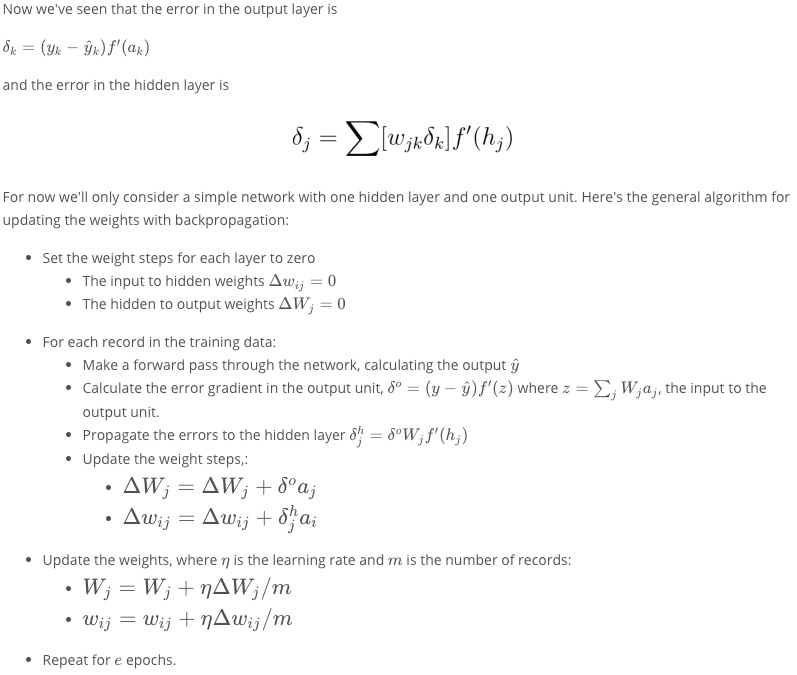


In [11]:
# Neural Network hyperparameters
epochs = 1000
learnrate = 0.1
last_loss = []

for e in range(epochs):
    del_w_input_hidden = np.zeros(weights_input_hidden.shape)
    del_w_hidden_output = np.zeros(weights_hidden_output.shape)
    for x, y in zip(features.values, targets):
        ## Forward pass ##
        # TODO: Calculate the output
        hidden_input = np.dot(x, weights_input_hidden)
        hidden_output = sigmoid(hidden_input)
        output = sigmoid(np.dot(hidden_output, weights_hidden_output))

        ## Backward pass ##
        # TODO: Calculate the error
        error = y - output

        # TODO: Calculate error gradient in output unit
        output_error = error * output * ( 1 - output )

        # TODO: propagate errors to hidden layer
        hidden_error = np.dot(output_error, weights_hidden_output) * hidden_output * ( 1 - hidden_output )

        # TODO: Update the change in weights
        del_w_hidden_output += output_error * hidden_output
        del_w_input_hidden += hidden_error * x[:, None]

    # TODO: Update weights
    weights_input_hidden += learnrate * del_w_input_hidden / n_records
    weights_hidden_output += learnrate * del_w_hidden_output / n_records

    # Printing out the mean square error on the training set
    if e % (epochs / 10) == 0:
        hidden_output = sigmoid(np.dot(x, weights_input_hidden))
        out = sigmoid(np.dot(hidden_output,
                             weights_hidden_output))
        loss = np.mean((out - targets) ** 2)

        if last_loss and last_loss < loss:
            print("Train loss: ", loss, "  WARNING - Loss Increasing")
        else:
            print("Train loss: ", loss)
        last_loss = loss


('Train loss: ', 0.2749080607365611)
('Train loss: ', 0.2509960178261504)
('Train loss: ', 0.23721654305876033)
('Train loss: ', 0.22924425059725057)
('Train loss: ', 0.22452702299851898)
('Train loss: ', 0.22166672955258432)
('Train loss: ', 0.21990079149158745)
('Train loss: ', 0.21880337124388266)
('Train loss: ', 0.21812836446731096)
('Train loss: ', 0.21772801585043022)


## (5) calculate accuracy on testing dataset

assume accuracy > 0.5 is good. That means our model should predict correctly on 50% samples of the testing dataset 

In [12]:
# Calculate accuracy on test data
hidden = sigmoid(np.dot(features_test, weights_input_hidden))
out = sigmoid(np.dot(hidden, weights_hidden_output))
predictions = out > 0.5
accuracy = np.mean(predictions == targets_test)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.700
